In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from IPython.core.display import display, HTML, Javascript

# ----- Notebook Theme -----
color_map = ['#6166B3', '#e8eff6', '#0b2553']

prompt = color_map[-1]
main_color = color_map[0]

css_file = '''

    div #notebook {
    background-color: white;
    line-height: 20px;
    }

    #notebook-container {
    %s
    margin-top: 2em;
    padding-top: 2em;
    border-top: 4px solid %s; /* light orange */
    -webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    }

    div .input {
    margin-bottom: 1em;
    }

    .rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
    color: %s; /* light orange */
    font-weight: 600;
    }

    div.input_area {
    border: none;
        background-color: %s; /* rgba(229, 143, 101, 0.1); light orange [exactly #E58F65] */
        border-top: 2px solid %s; /* light orange */
    }

    div.input_prompt {
    color: %s; /* light blue */
    }

    div.output_prompt {
    color: %s; /* strong orange */
    }

    div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
    background: %s; /* light orange */
    }

    div.cell.selected, div.cell.selected.jupyter-soft-selected {
        border-color: %s; /* light orange */
    }

    .edit_mode div.cell.selected:before {
    background: %s; /* light orange */
    }

    .edit_mode div.cell.selected {
    border-color: %s; /* light orange */

    }
    '''
def to_rgb(h):
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, main_color,  main_color, prompt, main_color, main_color, main_color, main_color))

def nb():
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score



In [5]:
data_df = pd.read_csv("fetal_health (1).csv")
data_df.sample(10)

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
411,147.0,0.000,0.000,0.002,0.002,0.0,0.000,71.0,0.3,17.0,...,139.0,154.0,0.0,0.0,143.0,145.0,146.0,1.0,0.0,2.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.000,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
1750,134.0,0.005,0.002,0.002,0.003,0.0,0.003,62.0,1.5,0.0,...,71.0,184.0,4.0,0.0,89.0,113.0,110.0,148.0,-1.0,3.0
1320,128.0,0.007,0.008,0.005,0.005,0.0,0.001,19.0,2.4,0.0,...,67.0,174.0,7.0,0.0,134.0,123.0,129.0,57.0,0.0,1.0
1372,121.0,0.008,0.000,0.005,0.000,0.0,0.000,32.0,1.0,0.0,...,110.0,157.0,1.0,0.0,131.0,131.0,131.0,8.0,0.0,1.0
1986,135.0,0.008,0.001,0.004,0.000,0.0,0.000,61.0,0.8,0.0,...,120.0,168.0,2.0,0.0,148.0,143.0,145.0,6.0,0.0,1.0
1563,144.0,0.004,0.000,0.006,0.000,0.0,0.000,40.0,0.8,0.0,...,112.0,171.0,3.0,0.0,160.0,154.0,157.0,8.0,1.0,1.0
424,143.0,0.000,0.000,0.002,0.000,0.0,0.000,65.0,0.6,7.0,...,129.0,158.0,4.0,1.0,150.0,145.0,146.0,5.0,0.0,2.0
1935,133.0,0.000,0.004,0.008,0.003,0.0,0.000,61.0,2.9,0.0,...,93.0,142.0,3.0,0.0,133.0,124.0,132.0,9.0,1.0,1.0
1859,138.0,0.017,0.000,0.004,0.000,0.0,0.000,51.0,0.9,0.0,...,122.0,171.0,4.0,0.0,147.0,149.0,150.0,5.0,0.0,1.0


In [6]:
# Checking for missing values and categorical variables in the dataset
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

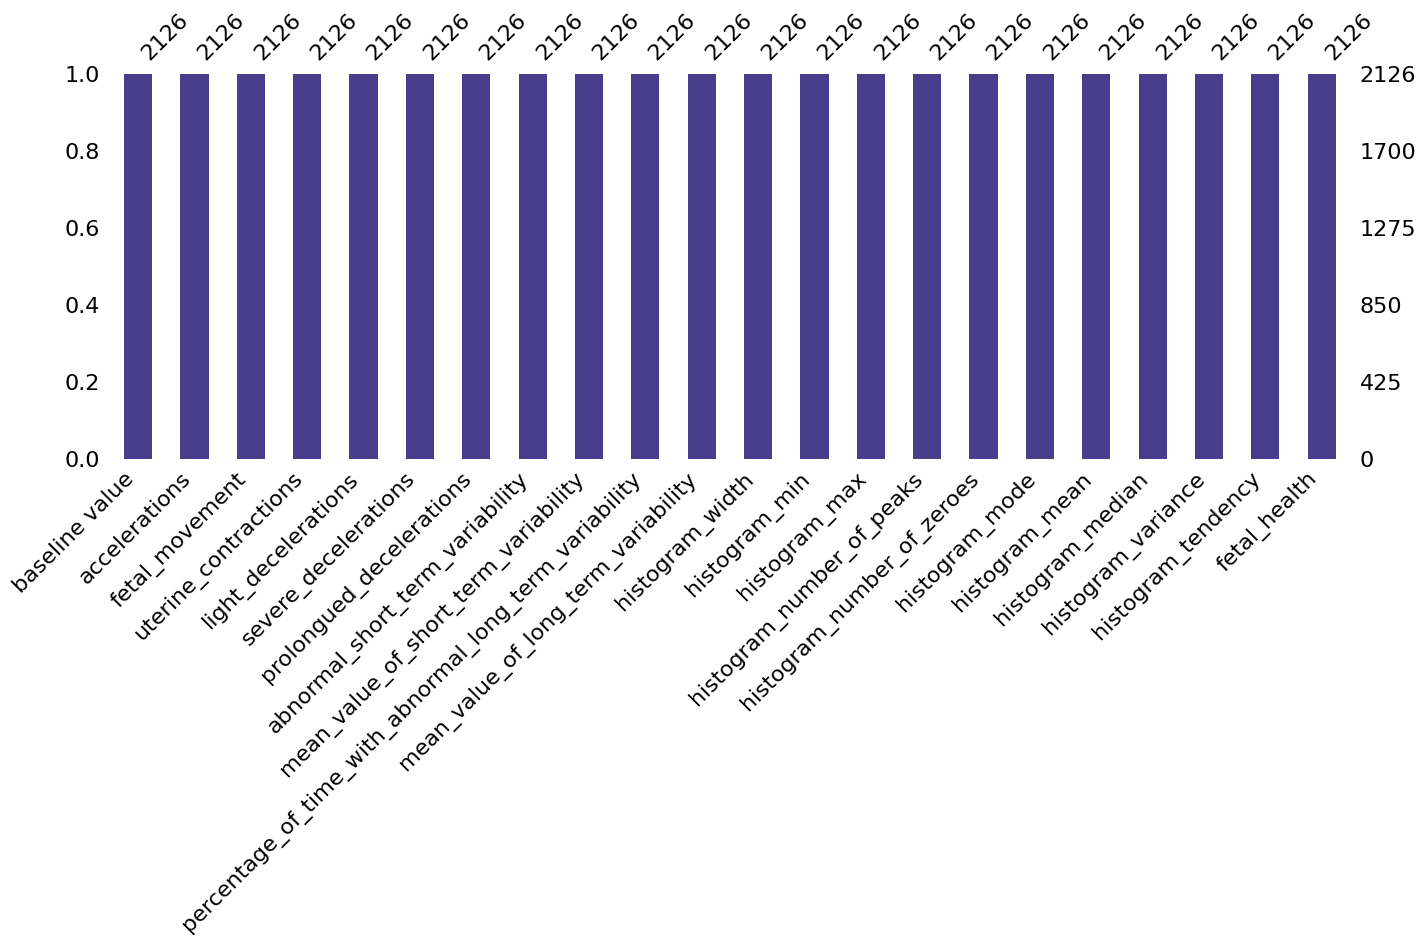

In [7]:
# Visualizing the missing values in the dataset,
missing_values = msno.bar(data_df, figsize = (16,5),color = "#483D8B")

In [8]:
# Doing Univariate Analysis for statistical description and understanding of dispersion of data
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


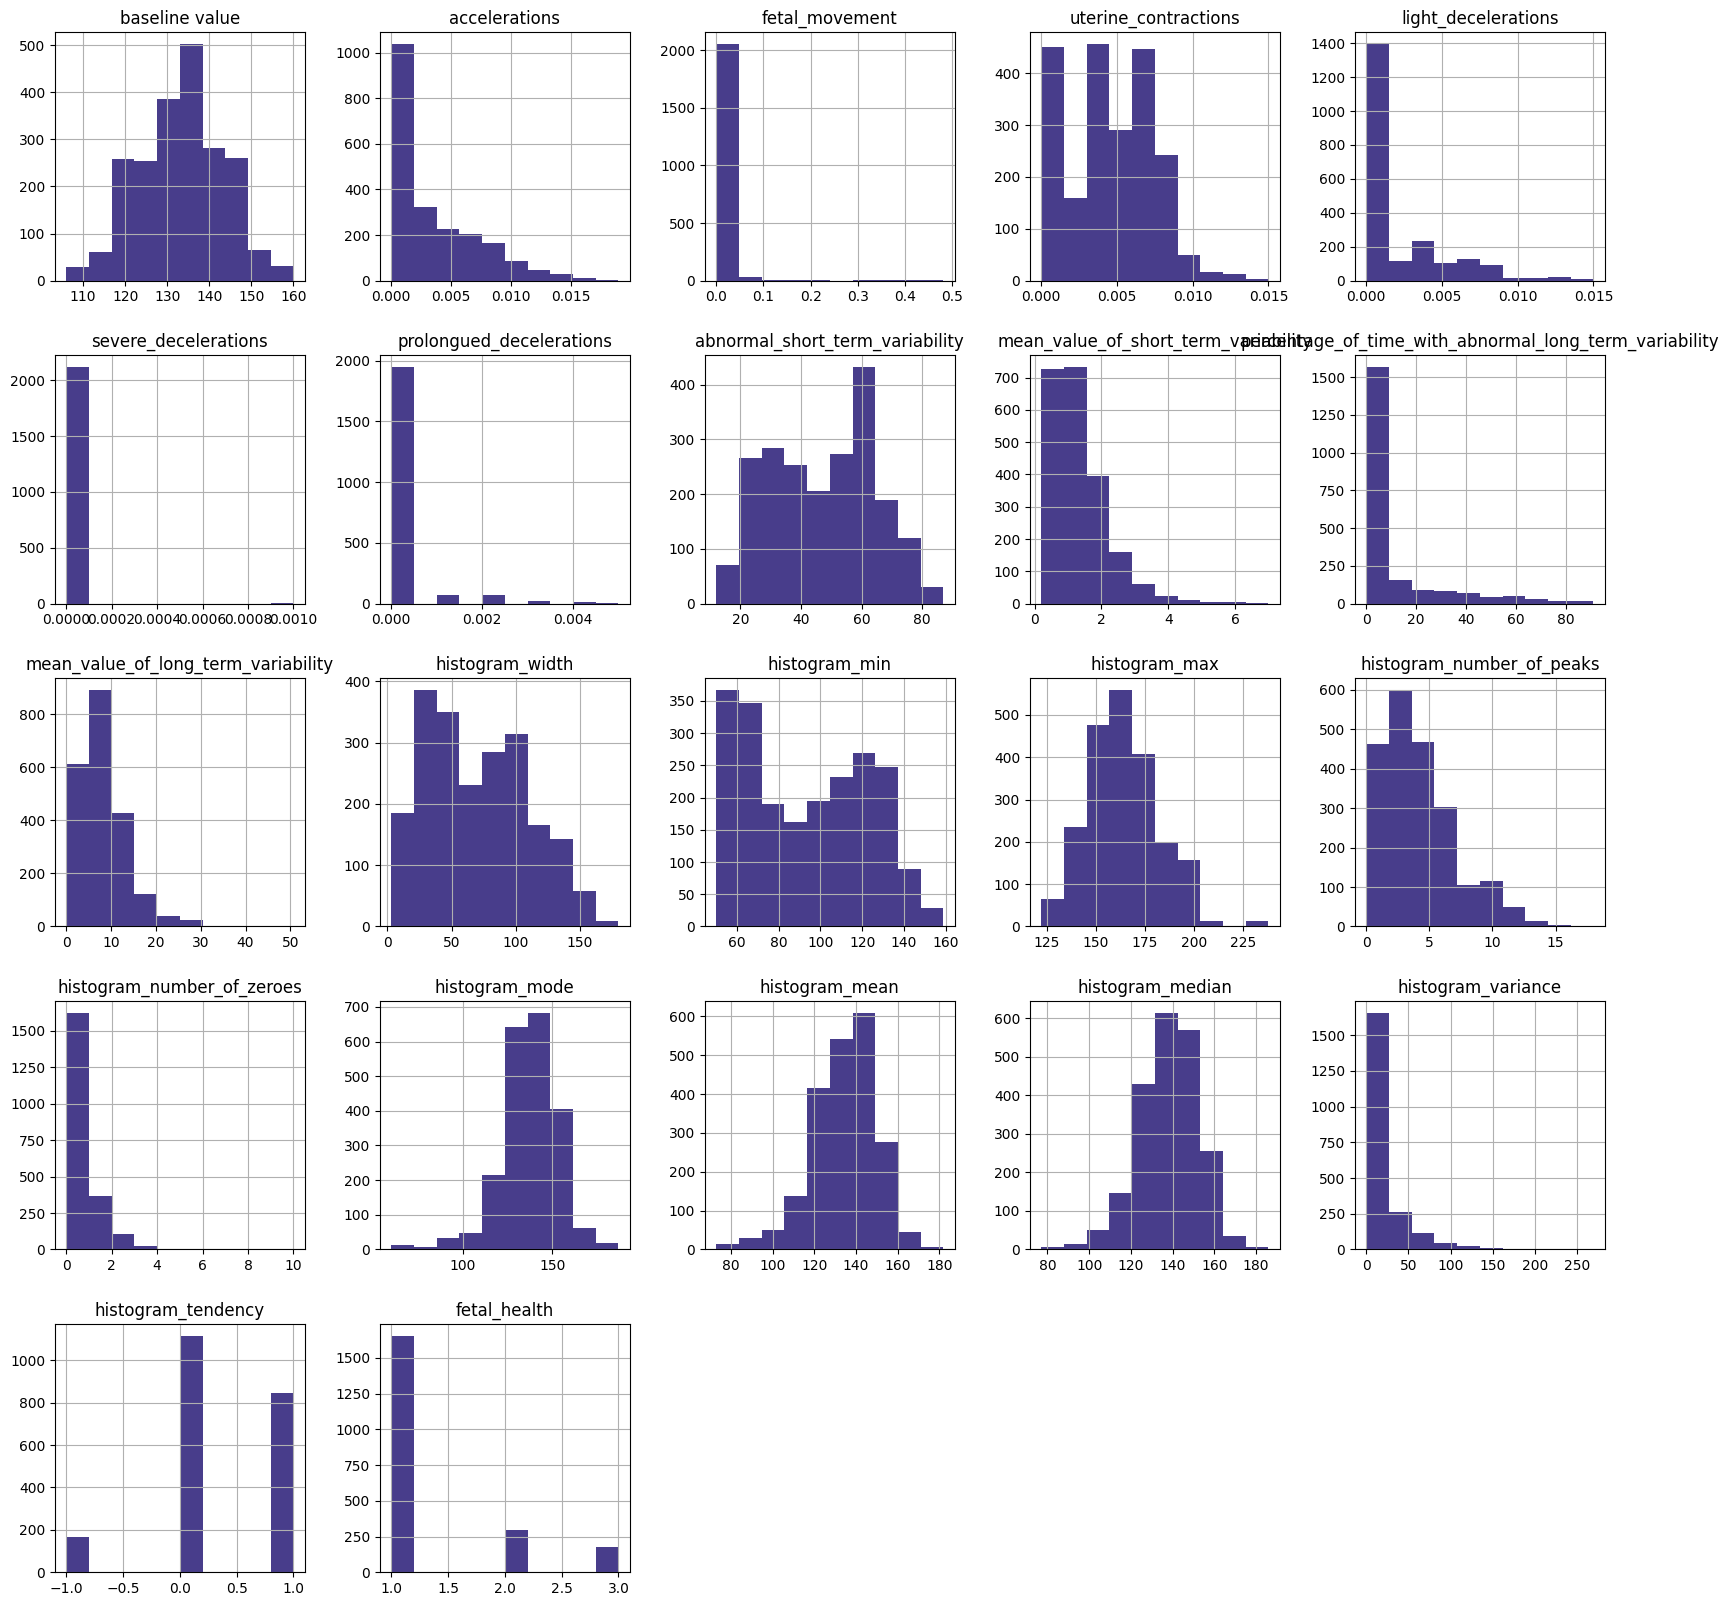

In [9]:
# Evaluating distributions of the features
hist_plot = data_df.hist(figsize = (20,20), color = "#483D8B")

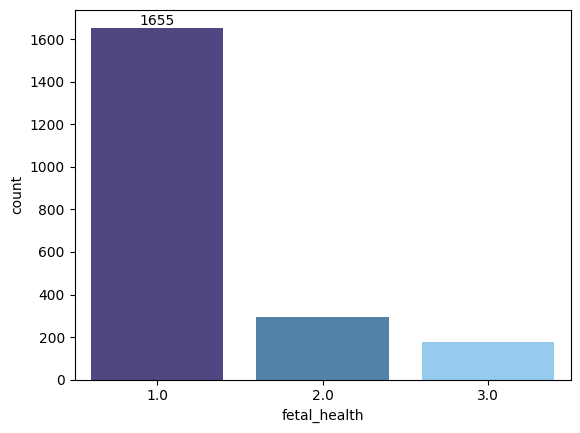

In [10]:
# Evaluating the target column and checking for imbalance of the data,
colors=["#483D8B","#4682B4", "#87CEFA"]
ax = sns.countplot(data= data_df, x="fetal_health", palette=colors)
ax.bar_label(ax.containers[0])
plt.show()

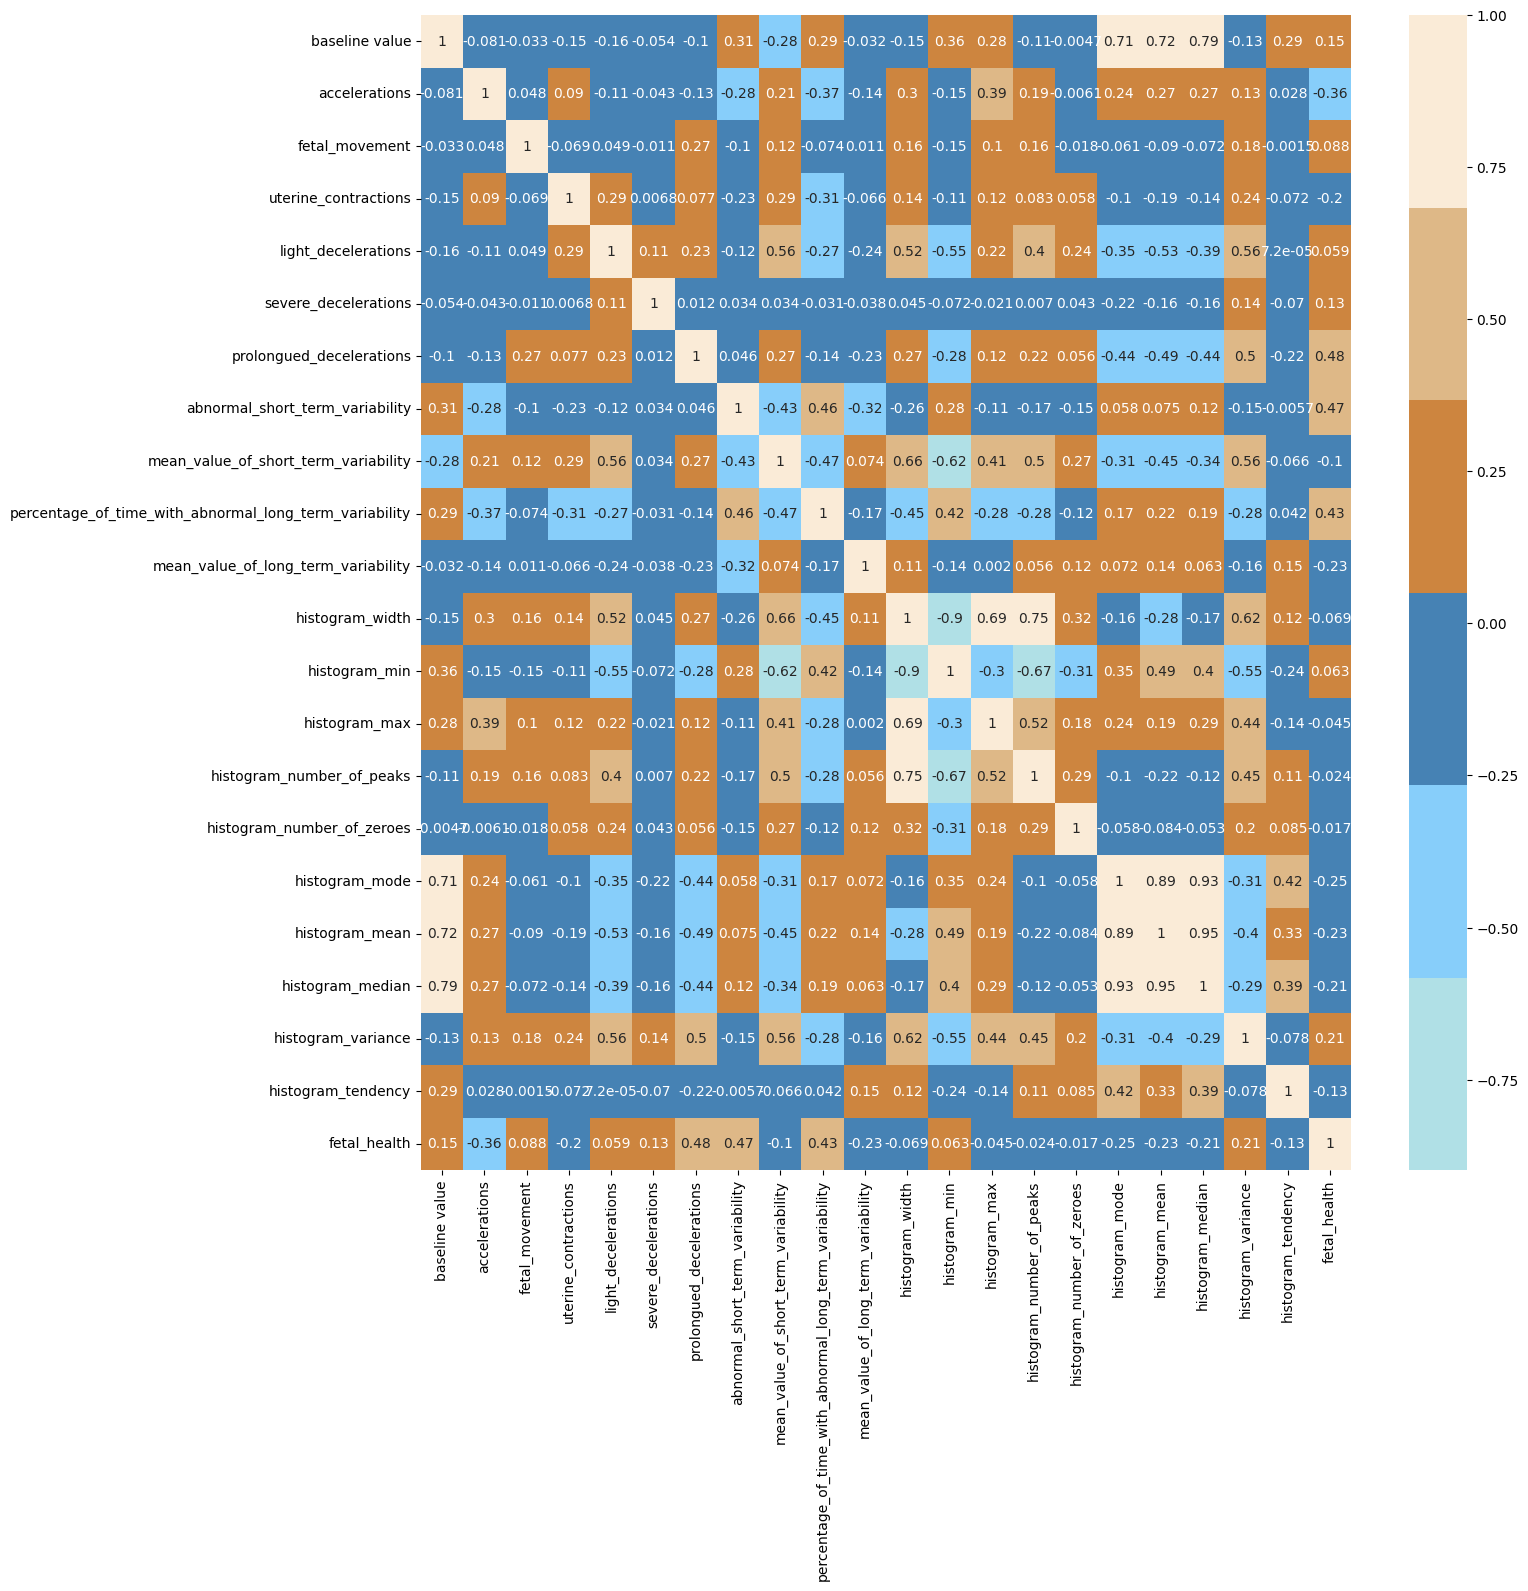

In [11]:
# Examining correlation matrix using heatmap
cmap = sns.diverging_palette(205, 133, 63, as_cmap=True)
cols = (["#B0E0E6", "#87CEFA", "#4682B4", "#CD853F", "#DEB887", "#FAEBD7"])

corrmat= data_df.corr()

f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrmat,cmap=cols,annot=True)
plt.show()

In [12]:
# Defining independent and dependent attributes in training and test sets
X=data_df.drop(["fetal_health"],axis=1)
y=data_df["fetal_health"]

In [13]:
col_names = list(X.columns)
s_scaler = StandardScaler()
X_scaled= s_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=col_names)
X_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,1.069490e-15,1.000235,-2.775197,-0.742373,-0.030884,0.680604,2.713428
accelerations,2126.0,-4.010589e-17,1.000235,-0.822388,-0.822388,-0.304881,0.730133,4.093929
fetal_movement,2126.0,-1.336863e-17,1.000235,-0.203210,-0.203210,-0.203210,-0.138908,10.106540
uterine_contractions,2126.0,-1.336863e-16,1.000235,-1.482465,-0.803434,-0.124404,0.894142,3.610264
light_decelerations,2126.0,-5.347452e-17,1.000235,-0.638438,-0.638438,-0.638438,0.375243,4.429965
severe_decelerations,2126.0,6.684315e-18,1.000235,-0.057476,-0.057476,-0.057476,-0.057476,17.398686
prolongued_decelerations,2126.0,1.336863e-17,1.000235,-0.268754,-0.268754,-0.268754,-0.268754,8.208570
abnormal_short_term_variability,2126.0,-7.352747e-17,1.000235,-2.035639,-0.872088,0.116930,0.815060,2.327675
mean_value_of_short_term_variability,2126.0,6.684315e-17,1.000235,-1.282833,-0.716603,-0.150373,0.415857,6.417893
percentage_of_time_with_abnormal_long_term_variability,2126.0,-5.347452e-17,1.000235,-0.535361,-0.535361,-0.535361,0.062707,4.412293


In [14]:
features=['baseline value', 'accelerations', 'fetal_movement','uterine_contractions', 'light_decelerations', 'severe_decelerations',
           'prolongued_decelerations', 'abnormal_short_term_variability', 'mean_value_of_short_term_variability',
             'percentage_of_time_with_abnormal_long_term_variability', 'mean_value_of_long_term_variability']

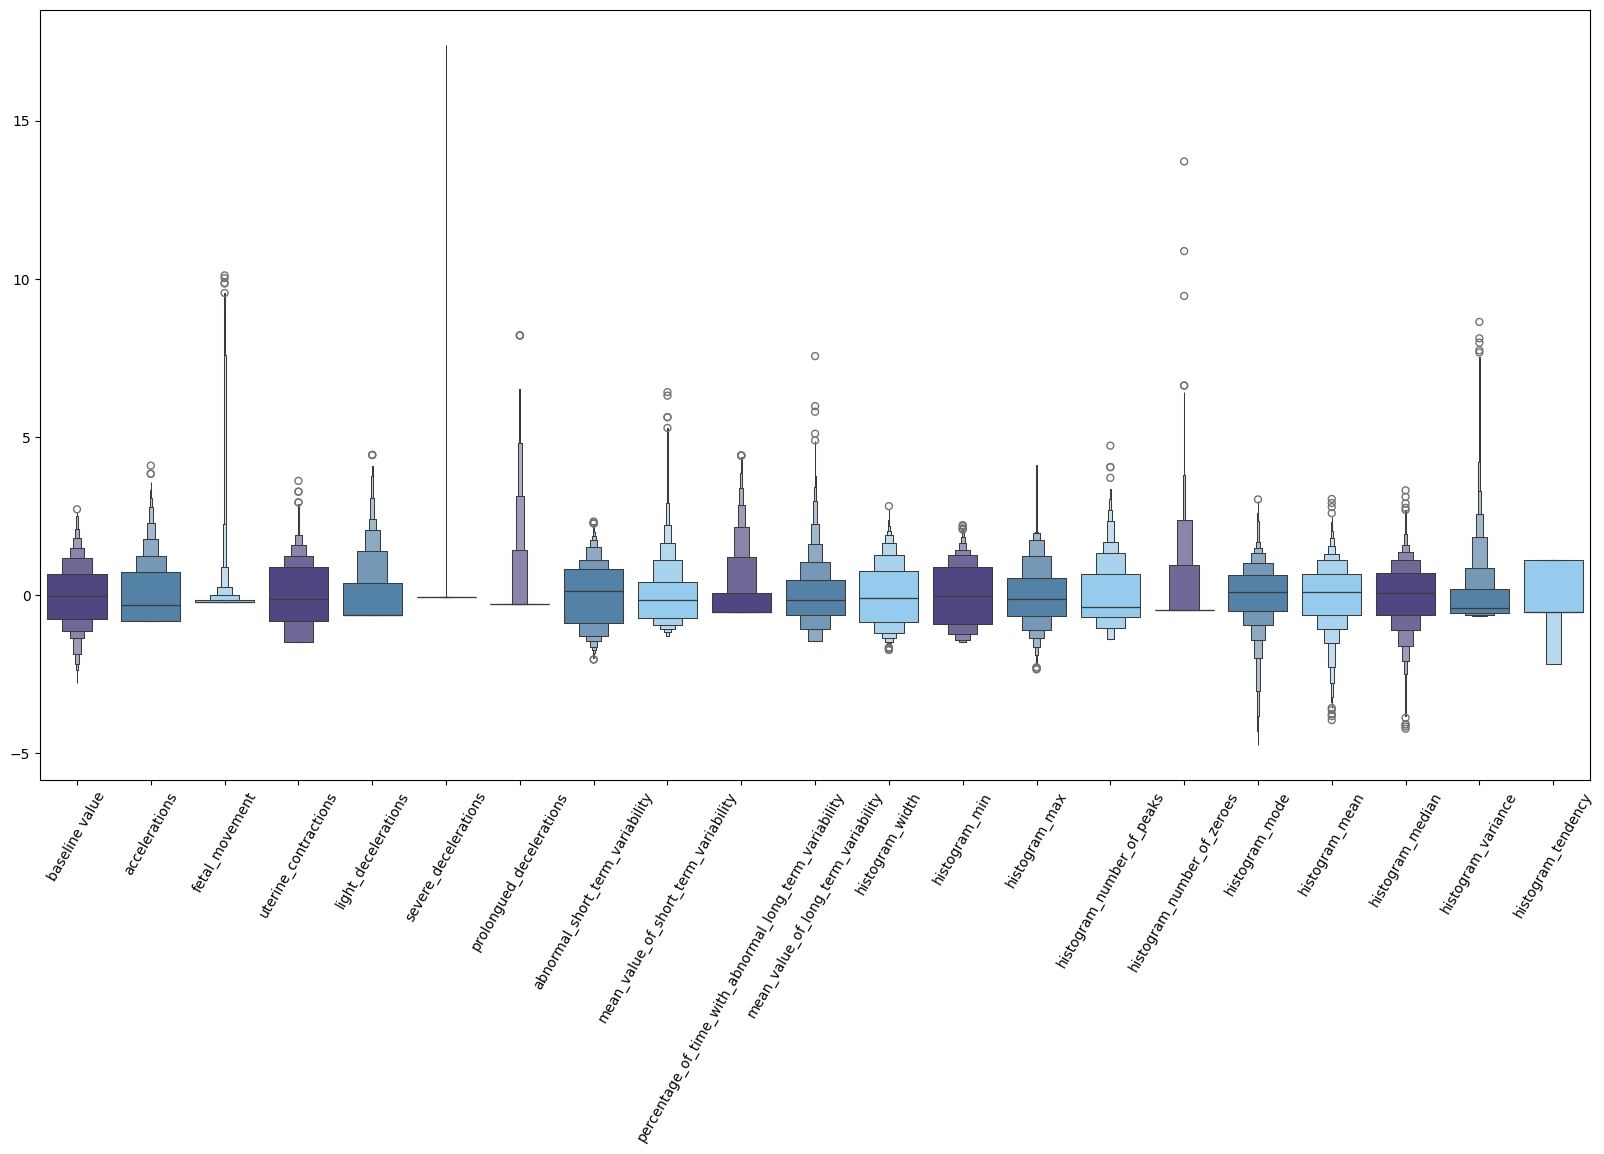

In [15]:
#Plotting the scaled features using boxen plots
plt.figure(figsize=(20,10))
sns.boxenplot(data = X_scaled,palette = colors)
plt.xticks(rotation=60)
plt.show()

In [16]:
# Splitting the training and test variables
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=25)

In [17]:
# Building pipelines of model for various classifiers

pipeline_lr = Pipeline([('lr_classifier',LogisticRegression())])

pipeline_dt = Pipeline([('dt_classifier',DecisionTreeClassifier())])

pipeline_gbcl = Pipeline([('gbcl_classifier',GradientBoostingClassifier())])

pipeline_rf = Pipeline([('rf_classifier',RandomForestClassifier())])

pipeline_knn = Pipeline([('knn_classifier',KNeighborsClassifier())])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_gbcl, pipeline_rf, pipeline_knn]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'Gradient Boost', 3:'RandomForest', 4: 'KNN'}


# Fitting the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [18]:
cv_results_accuracy = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train, cv=12)
    cv_results_accuracy.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

Logistic Regression: 0.865315 
Decision Tree: 0.927680 
Gradient Boost: 0.944120 
RandomForest: 0.935904 
KNN: 0.887070 


In [19]:
# Baseline model of gradient boosting classifier with default parameters:
gbcl = GradientBoostingClassifier()
gbcl_model = gbcl.fit(X_train, y_train)
print(f"Baseline Gradient Boosting Classifier Score: {round(gbcl_model.score(X_test, y_test), 2)}")

pred_gbcl = gbcl_model.predict(X_test)

Baseline Gradient Boosting Classifier Score: 0.96


In [20]:
# Cross validate Gradient Boosting Classifier model
scores_gbcl = cross_val_score(gbcl, X_train, y_train, cv = 8, n_jobs = 2, scoring = "accuracy")

print(f"CV scores for Gradient Boosting Classifier model:\n{scores_gbcl}")
print(f"CV Mean score: {round(scores_gbcl.mean(), 2)}")

CV scores for Gradient Boosting Classifier model:
[0.96244131 0.93896714 0.92488263 0.94366197 0.97641509 0.95283019
 0.93396226 0.95754717]
CV Mean score: 0.95


In [21]:
parameters = {"loss": ["deviance"],
              "learning_rate": [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1],
              "n_estimators": [200, 350, 500, 750],
              "max_depth": [3, 6, 8]
              }

In [22]:
GridSearchCV_gbcl = GridSearchCV(estimator=GradientBoostingClassifier(),
                                param_grid=parameters,
                                cv=2,
                                verbose=1,
                                n_jobs=3,
                                scoring="accuracy",
                                return_train_score=True
                                )

In [23]:
GridSearchCV_gbcl.fit(X_train, y_train);

Fitting 2 folds for each of 84 candidates, totalling 168 fits


In [24]:
best_parameters = GridSearchCV_gbcl.best_params_
print(f"Best parameters for the model:\n{best_parameters}")

Best parameters for the model:
{'learning_rate': 0.75, 'loss': 'deviance', 'max_depth': 6, 'n_estimators': 500}


In [27]:
# Testing with the best parameters,

gbcl = GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.1, loss="deviance",
                                  max_depth=6, max_features="log2", min_samples_leaf=0.3,
                                  min_samples_split=0.5, n_estimators=500, random_state=25)

gbcl_mod = gbcl.fit(X_train, y_train)
pred_gbcl = gbcl_mod.predict(X_test)

score_gbcl_train = gbcl_mod.score(X_train, y_train)
score_gbcl_test = gbcl_mod.score(X_test, y_test)

In [28]:
print(f"r^2(coefficient of determination) on training set = {round(score_gbcl_train, 3)}")
print(f"r^2(coefficient of determination) on testing set = {round(score_gbcl_test, 3)}")

r^2(coefficient of determination) on training set = 0.932
r^2(coefficient of determination) on testing set = 0.904


In [29]:
# Getting score on the Test set,

pred_gbcl = pipeline_gbcl.predict(X_test)
accuracy = accuracy_score(y_test, pred_gbcl)
print(f" Testing Score of the model is {accuracy}")

 Testing Score of the model is 0.9624413145539906


In [30]:
# Getting the Classification report
print(classification_report(y_test, pred_gbcl))

              precision    recall  f1-score   support

         1.0       0.98      0.98      0.98       324
         2.0       0.93      0.87      0.90        60
         3.0       0.91      0.95      0.93        42

    accuracy                           0.96       426
   macro avg       0.94      0.93      0.94       426
weighted avg       0.96      0.96      0.96       426



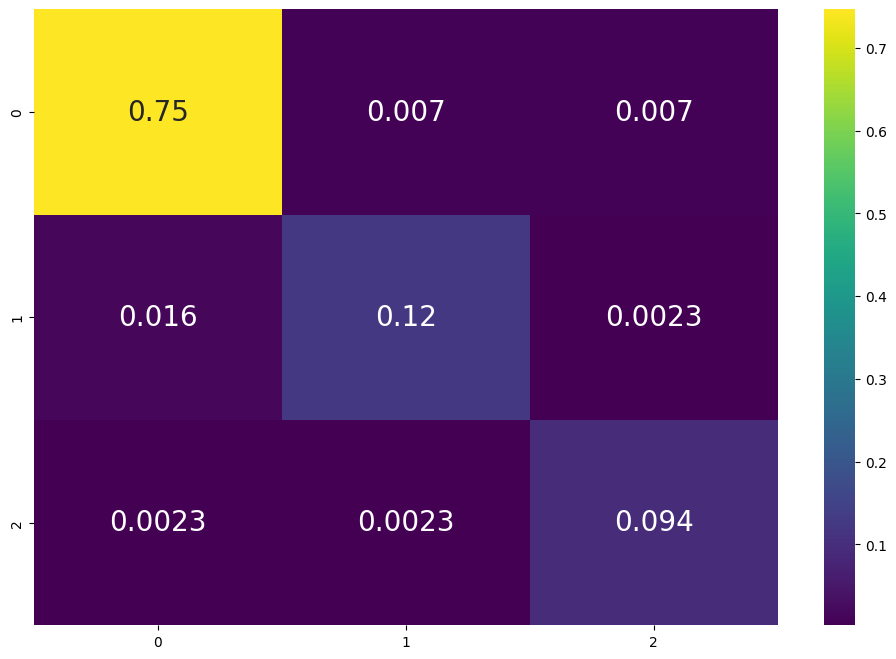

In [31]:
# Getting the Confusion matrix
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, pred_gbcl)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap='viridis',annot = True, annot_kws = {'size':20})
plt.show()

In [32]:
print(f"r^2(coefficient of determination) on training set = {round(score_gbcl_train, 3)}")
print(f"r^2(coefficient of determination) on testing set = {round(score_gbcl_test, 3)}")

r^2(coefficient of determination) on training set = 0.932
r^2(coefficient of determination) on testing set = 0.904


In [33]:
# Getting score on the Test set,

pred_gbcl = pipeline_gbcl.predict(X_test)
accuracy = accuracy_score(y_test, pred_gbcl)
print(f" Testing Score of the model is {accuracy}")

 Testing Score of the model is 0.9624413145539906


In [34]:
# Getting the Classification report
print(classification_report(y_test, pred_gbcl))

              precision    recall  f1-score   support

         1.0       0.98      0.98      0.98       324
         2.0       0.93      0.87      0.90        60
         3.0       0.91      0.95      0.93        42

    accuracy                           0.96       426
   macro avg       0.94      0.93      0.94       426
weighted avg       0.96      0.96      0.96       426



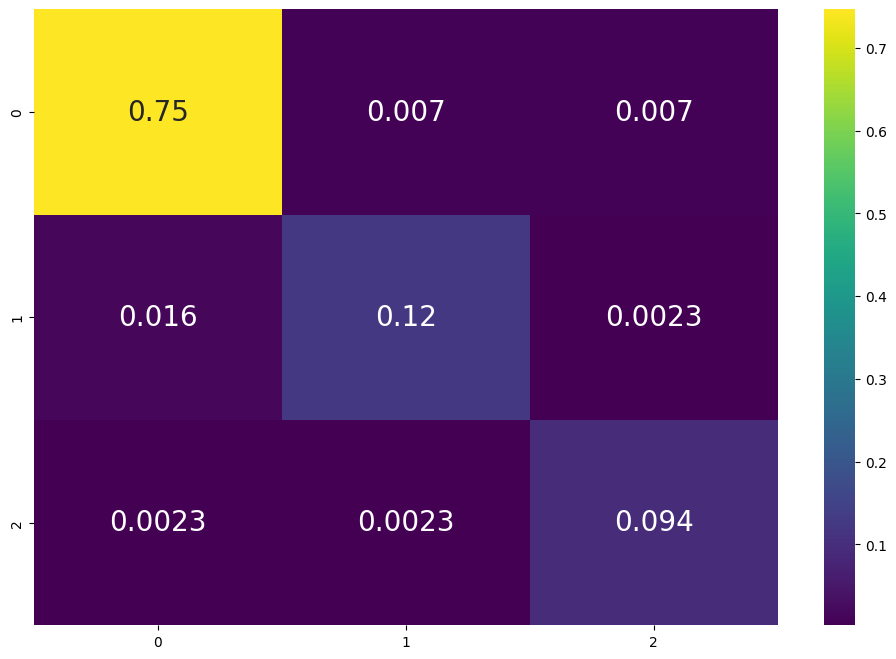

In [35]:
# Getting the Confusion matrix
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, pred_gbcl)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap='viridis',annot = True, annot_kws = {'size':20})
plt.show()